# Домашнее задание 3

In [1]:
import math
import os
import random
import time
from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from datasets import DatasetDict, load_dataset
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
)
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.transforms import InterpolationMode
from tqdm.auto import tqdm

## Подготовка данных и бейзлайн модели

Код из секции ниже взят из ноутбука с практикой. Здесь выполняется:

- объявление функции для контроля состояния random seed
- загрузка датасета
- создание уменьшенной (15 категорий) выборки из оригинального датасета
- разбиение на train, test и val
- препроцессинг датасета (уменьшение размерности до измерений, подходящих выбранной модели)
- построение, обучение бейзлайн модели и вычисление метрик для нее

Поскольку бейзлайн модель нужна нам для того, чтобы сравнивать с ней различные методы улучшения генерализации, сейчас не будем подробно останавливаться на результатах и обсудим их ниже, уже в сравнении с другими вариациями

Далее попробуем два способа улучшения генерализации для бейзлайн модели

In [2]:
def set_seed(seed: int = 42) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(100)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Device: cuda


In [4]:
DATA_CACHE_DIR = "./data_cache"
ds = load_dataset("food101", cache_dir=DATA_CACHE_DIR)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [7]:
train_hf = ds["train"]
test_hf  = ds["validation"]

class_names = train_hf.features["label"].names
num_classes = len(class_names)
print(f"Total classes: {num_classes}")
print("Class names:", class_names)

Total classes: 101
Class names: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_an

In [8]:
print(f"Train size: {len(train_hf):,} | Test size: {len(test_hf):,}")

Train size: 75,750 | Test size: 25,250


In [9]:
def show_images(split, idxs=None, rows=3, cols=3, seed=42, title="Image samples"):
    set_seed(seed)
    if idxs is None:
        idxs = random.sample(range(len(split)), k=min(rows * cols, len(split)))
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
    fig.suptitle(title, y=0.98, fontsize=12)
    for ax, i in zip(axs.ravel(), idxs):
        ex = split[int(i)]
        img, label = ex["image"], class_names[int(ex["label"])]
        ax.imshow(img)
        ax.set_title(label, fontsize=8)
        ax.axis("off")
    for ax in axs.ravel()[len(idxs):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

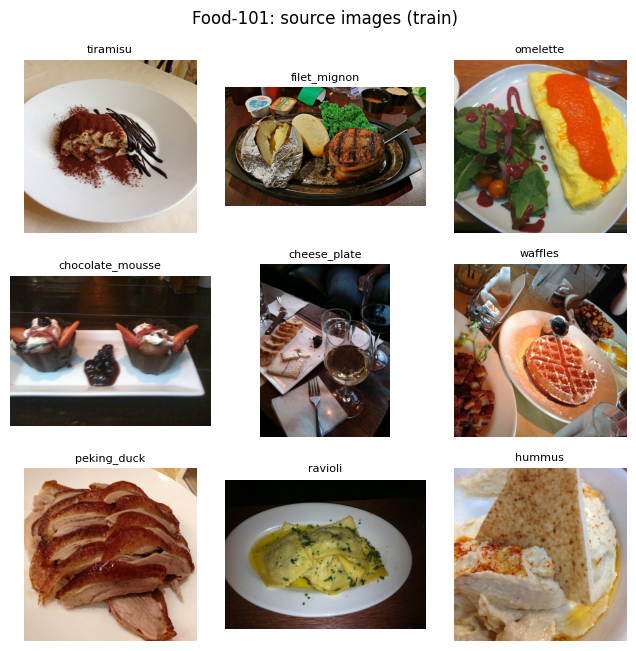

In [10]:
image_samples = random.sample(range(len(train_hf)), k=min(3 * 3, len(train_hf)))
show_images(train_hf, idxs=image_samples, title="Food-101: source images (train)")

In [11]:
K_CLASSES = 15
TRAIN_PER_CLASS = 600
VAL_PER_CLASS = 150
TEST_PER_CLASS = 250

In [12]:
all_cls_ids = np.arange(len(class_names))
random.shuffle(all_cls_ids)
chosen_cls = np.sort(all_cls_ids[:K_CLASSES])
chosen_names = [class_names[i] for i in chosen_cls]
print(f"Picked {K_CLASSES} classes:\n", chosen_names)

Picked 15 classes:
 ['baby_back_ribs', 'breakfast_burrito', 'bruschetta', 'ceviche', 'deviled_eggs', 'dumplings', 'french_toast', 'fried_rice', 'hot_dog', 'macarons', 'nachos', 'panna_cotta', 'poutine', 'prime_rib', 'waffles']


In [13]:
by_lbl_train = defaultdict(list)
for i, y in enumerate(train_hf["label"]):
    if y in chosen_cls:
        by_lbl_train[int(y)].append(i)

by_lbl_test = defaultdict(list)
for i, y in enumerate(test_hf["label"]):
    if y in chosen_cls:
        by_lbl_test[int(y)].append(i)

In [14]:
train_idx_total, val_idx_total, test_idx_total = [], [], []
for c in chosen_cls:
    tr_ids = by_lbl_train[int(c)]
    random.shuffle(tr_ids)
    need_val = min(VAL_PER_CLASS, len(tr_ids))
    need_train = min(TRAIN_PER_CLASS, max(0, len(tr_ids) - need_val))

    val_idx_c = tr_ids[:need_val]
    train_idx_c = tr_ids[need_val:need_val + need_train]

    te_ids = by_lbl_test[int(c)]
    random.shuffle(te_ids)
    test_idx_c = te_ids[:min(TEST_PER_CLASS, len(te_ids))]

    val_idx_total.extend(val_idx_c)
    train_idx_total.extend(train_idx_c)
    test_idx_total.extend(test_idx_c)

In [15]:
len(train_idx_total), len(val_idx_total), len(test_idx_total)

(9000, 2250, 3750)

In [16]:
train_small = train_hf.select(train_idx_total)
val_small = train_hf.select(val_idx_total)
test_small = test_hf.select(test_idx_total)

food101_small = DatasetDict({
    "train": train_small,
    "val":   val_small,
    "test":  test_small
})

In [17]:
def balance_table(split, title):
    cnt = Counter(split["label"])
    df = pd.DataFrame({
        "class_id": chosen_cls,
        "class": [class_names[i] for i in chosen_cls],
        "count": [cnt.get(int(c), 0) for c in chosen_cls],
    }).sort_values("class").reset_index(drop=True)
    print(f"{title} (N={len(split)})"); display(df)
    return df

In [18]:
bt_train = balance_table(food101_small["train"], "TRAIN (MINI-15)")

TRAIN (MINI-15) (N=9000)


class_id              class  count
0          1     baby_back_ribs    600
1          9  breakfast_burrito    600
2         10         bruschetta    600
3         15            ceviche    600
4         30       deviled_eggs    600
5         32          dumplings    600
6         42       french_toast    600
7         44         fried_rice    600
8         55            hot_dog    600
9         63           macarons    600
10        66             nachos    600
11        73        panna_cotta    600
12        78            poutine    600
13        79          prime_rib    600
14       100            waffles    600

In [19]:
bt_val = balance_table(food101_small["val"],   "VAL   (MINI-15)")

VAL   (MINI-15) (N=2250)


class_id              class  count
0          1     baby_back_ribs    150
1          9  breakfast_burrito    150
2         10         bruschetta    150
3         15            ceviche    150
4         30       deviled_eggs    150
5         32          dumplings    150
6         42       french_toast    150
7         44         fried_rice    150
8         55            hot_dog    150
9         63           macarons    150
10        66             nachos    150
11        73        panna_cotta    150
12        78            poutine    150
13        79          prime_rib    150
14       100            waffles    150

In [20]:
bt_test = balance_table(food101_small["test"],  "TEST  (MINI-15)")

TEST  (MINI-15) (N=3750)


class_id              class  count
0          1     baby_back_ribs    250
1          9  breakfast_burrito    250
2         10         bruschetta    250
3         15            ceviche    250
4         30       deviled_eggs    250
5         32          dumplings    250
6         42       french_toast    250
7         44         fried_rice    250
8         55            hot_dog    250
9         63           macarons    250
10        66             nachos    250
11        73        panna_cotta    250
12        78            poutine    250
13        79          prime_rib    250
14       100            waffles    250

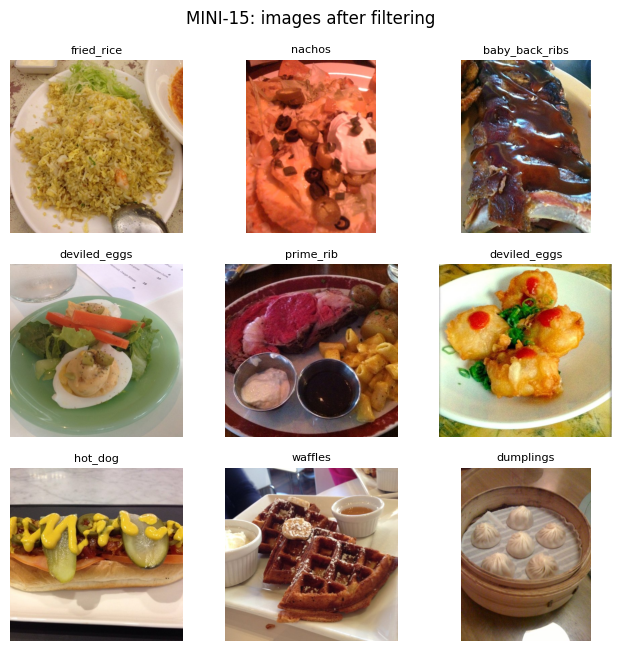

In [21]:
SAMPLE_IDX = random.sample(range(len(food101_small["train"])), 9)
show_images(food101_small["train"], SAMPLE_IDX, title="MINI-15: images after filtering")

In [22]:
LABEL2NEW = {int(old): i for i, old in enumerate(chosen_cls)}
NEW2LABEL = {v: k for k, v in LABEL2NEW.items()}

NUM_CLASSES = len(chosen_cls)
print("NUM_CLASSES =", NUM_CLASSES)
list(LABEL2NEW.items())

NUM_CLASSES = 15


[(1, 0),
 (9, 1),
 (10, 2),
 (15, 3),
 (30, 4),
 (32, 5),
 (42, 6),
 (44, 7),
 (55, 8),
 (63, 9),
 (66, 10),
 (73, 11),
 (78, 12),
 (79, 13),
 (100, 14)]

In [23]:
IMG_SIZE = 224
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

baseline_tf = T.Compose([
    T.Resize(256, interpolation=InterpolationMode.BILINEAR),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])

In [24]:
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_split, transform, label_map):
        self.data = hf_split
        self.tf = transform
        self.label_map = label_map
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[int(idx)]
        x = self.tf(ex["image"])
        y_old = int(ex["label"])
        y = self.label_map[y_old]
        return x, y

In [25]:
train_ds = HFDataset(food101_small["train"], baseline_tf, LABEL2NEW)
val_ds = HFDataset(food101_small["val"], baseline_tf, LABEL2NEW)
test_ds = HFDataset(food101_small["test"], baseline_tf, LABEL2NEW)

In [26]:
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}, batch={BATCH_SIZE}")

train=9000, val=2250, test=3750, batch=64


In [27]:
xb, yb = next(iter(train_loader))
print('Batch shape:', xb.shape, yb.shape)

Batch shape: torch.Size([64, 3, 224, 224]) torch.Size([64])


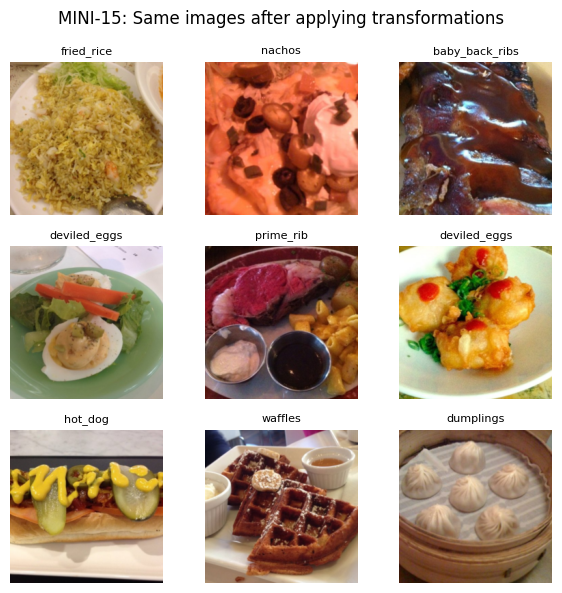

In [28]:
mean = torch.tensor(MEAN)[:, None, None]
std  = torch.tensor(STD)[:, None, None]
fig, axs = plt.subplots(3, 3, figsize=(6,6))
fig.suptitle("MINI-15: Same images after applying transformations", y=0.98, fontsize=12)

for ax, idx in zip(axs.ravel(), SAMPLE_IDX):
    ex = food101_small["train"][idx]
    img_after = baseline_tf(ex["image"])
    img_show = (img_after * std + mean).permute(1,2,0).numpy().clip(0,1)
    ax.imshow(img_show)
    ax.set_title(class_names[int(ex["label"])], fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [29]:
USE_PRETRAINED = True

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if USE_PRETRAINED else None)

for name, param in model.named_parameters():
    param.requires_grad = False

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


In [30]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"ResNet-18 total params: {total_params/1e6:.2f}M\n",
      f"ResNet-18 trainable params: {trainable_params/1e6:.2f}M")

ResNet-18 total params: 11.18M
 ResNet-18 trainable params: 0.01M


In [31]:
xb, yb = next(iter(train_loader))
xb = xb.to(device)
with torch.no_grad():
    out = model(xb)

out.shape

torch.Size([64, 15])

In [32]:
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(1)
    return (preds == targets).float().mean().item()

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

EPOCHS = 10
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

best_val_loss = float("inf")
patience = 3
no_improve_epochs = 0
checkpoint_path = "best_model.pt"

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = train_acc = 0.0
    n_train = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        bs = yb.size(0)
        n_train += bs
        train_loss += loss.item() * bs
        train_acc  += accuracy_from_logits(logits, yb) * bs

    train_loss /= n_train
    train_acc  /= n_train

    model.eval()
    val_loss = val_acc = 0.0
    n_val = 0
    for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [val]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        with torch.no_grad():
            logits = model(xb)
            loss = criterion(logits, yb)
        bs = yb.size(0)
        n_val += bs
        val_loss += loss.item() * bs
        val_acc  += accuracy_from_logits(logits, yb) * bs

    val_loss /= n_val
    val_acc  /= n_val

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} | "
          f"train_acc={train_acc*100:.1f}% val_acc={val_acc*100:.1f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss,
        }, checkpoint_path)
        print("new checkpoint")
    else:
        no_improve_epochs += 1
        print(f"no improvements for {no_improve_epochs} epochs in a row")

    if no_improve_epochs >= patience:
        print("early stopping")
        break

Epoch 1/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 1/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 01/10 | train_loss=1.7361 val_loss=1.1733 | train_acc=51.3% val_acc=68.5%
new checkpoint


Epoch 2/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 2/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 02/10 | train_loss=1.0770 val_loss=0.9740 | train_acc=70.6% val_acc=71.3%
new checkpoint


Epoch 3/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 3/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 03/10 | train_loss=0.9186 val_loss=0.8953 | train_acc=73.5% val_acc=72.6%
new checkpoint


Epoch 4/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 4/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 04/10 | train_loss=0.8408 val_loss=0.8635 | train_acc=75.4% val_acc=72.9%
new checkpoint


Epoch 5/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 5/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 05/10 | train_loss=0.8061 val_loss=0.8337 | train_acc=75.8% val_acc=74.1%
new checkpoint


Epoch 6/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 6/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 06/10 | train_loss=0.7642 val_loss=0.8313 | train_acc=76.9% val_acc=73.8%
new checkpoint


Epoch 7/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 7/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 07/10 | train_loss=0.7409 val_loss=0.8088 | train_acc=77.5% val_acc=74.7%
new checkpoint


Epoch 8/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 8/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 08/10 | train_loss=0.7125 val_loss=0.7988 | train_acc=78.2% val_acc=75.0%
new checkpoint


Epoch 9/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 9/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 09/10 | train_loss=0.6908 val_loss=0.8000 | train_acc=78.7% val_acc=74.6%
no improvements for 1 epochs in a row


Epoch 10/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 10/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/10 | train_loss=0.6752 val_loss=0.7858 | train_acc=79.3% val_acc=75.2%
new checkpoint


In [34]:
@torch.no_grad()
def evaluate(model, dataloader):
    """Calculate accuracy and macro-F1 on specified split."""
    model.eval()
    all_preds, all_labels = [], []
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return acc, f1

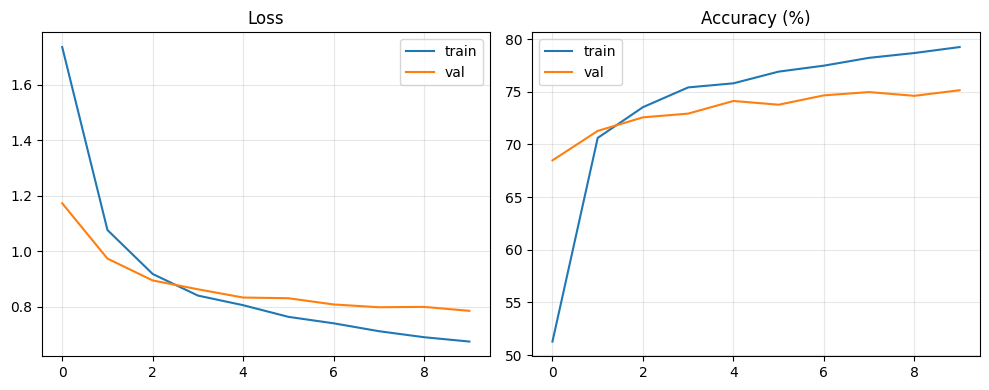

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(history["train_loss"], label="train")
axs[0].plot(history["val_loss"],   label="val")
axs[0].set_title("Loss"); axs[0].legend(); axs[0].grid(True, alpha=0.3)

axs[1].plot(np.array(history["train_acc"])*100, label="train")
axs[1].plot(np.array(history["val_acc"])*100,   label="val")
axs[1].set_title("Accuracy (%)"); axs[1].legend(); axs[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [36]:
val_acc, val_f1 = evaluate(model, val_loader)
test_acc, test_f1 = evaluate(model, test_loader)
print(f"[VAL]  Acc={val_acc*100:.2f}% | Macro-F1={val_f1:.3f}")
print(f"[TEST] Acc={test_acc*100:.2f}% | Macro-F1={test_f1:.3f}")

[VAL]  Acc=75.16% | Macro-F1=0.750
[TEST] Acc=78.93% | Macro-F1=0.788


In [37]:
sns.set_context("notebook")

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Eval [test]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

print(f"Samples: {len(y_true)}")

Eval [test]:   0%|          | 0/59 [00:00<?, ?it/s]

Samples: 3750


In [38]:
class_names_small = [class_names[i] for i in chosen_cls]

report = classification_report(
    y_true, y_pred,
    target_names=class_names_small,
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report).transpose()

In [39]:
class_rows = [c for c in report_df.index if c not in ["accuracy", "macro avg", "weighted avg"]]
class_metrics = report_df.loc[class_rows]

display(class_metrics)

precision  recall  f1-score  support
baby_back_ribs      0.776824   0.724  0.749482    250.0
breakfast_burrito   0.739130   0.680  0.708333    250.0
bruschetta          0.674797   0.664  0.669355    250.0
ceviche             0.729167   0.560  0.633484    250.0
deviled_eggs        0.794677   0.836  0.814815    250.0
dumplings           0.897638   0.912  0.904762    250.0
french_toast        0.666667   0.832  0.740214    250.0
fried_rice          0.837121   0.884  0.859922    250.0
hot_dog             0.766892   0.908  0.831502    250.0
macarons            0.948000   0.948  0.948000    250.0
nachos              0.707317   0.696  0.701613    250.0
panna_cotta         0.839506   0.816  0.827586    250.0
poutine             0.838057   0.828  0.832998    250.0
prime_rib           0.850679   0.752  0.798301    250.0
waffles             0.790514   0.800  0.795229    250.0

In [40]:
summary_metrics = report_df.loc[["accuracy", "macro avg", "weighted avg"]]

display(summary_metrics)

precision    recall  f1-score      support
accuracy       0.789333  0.789333  0.789333     0.789333
macro avg      0.790466  0.789333  0.787706  3750.000000
weighted avg   0.790466  0.789333  0.787706  3750.000000

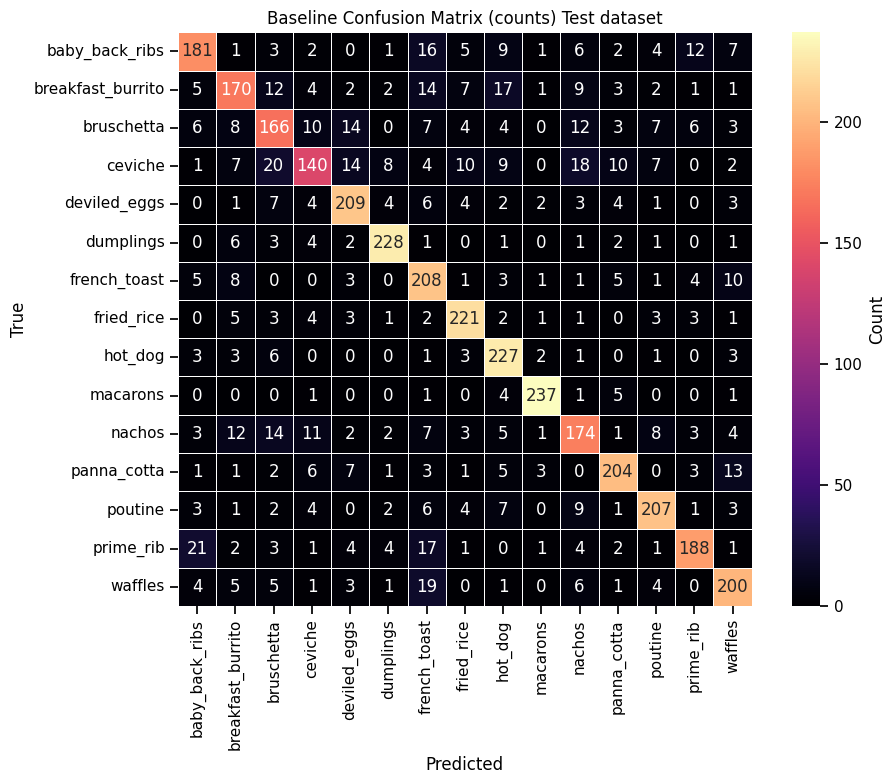

In [119]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    cm, annot=True, fmt="d",
    cmap="magma",
    linewidths=0.5, linecolor="white",
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_names_small,
    yticklabels=class_names_small,
    ax=ax
)

ax.set_title("Baseline Confusion Matrix (counts) Test dataset")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [117]:
model.eval()
y_true_val, y_pred_val = [], []

with torch.no_grad():
    for xb, yb in tqdm(val_loader, desc="Eval [val]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1)
        y_true_val.extend(yb.cpu().numpy())
        y_pred_val.extend(preds.cpu().numpy())

y_true_val = np.array(y_true_val, dtype=int)
y_pred_val = np.array(y_pred_val, dtype=int)

Eval [val]:   0%|          | 0/36 [00:00<?, ?it/s]

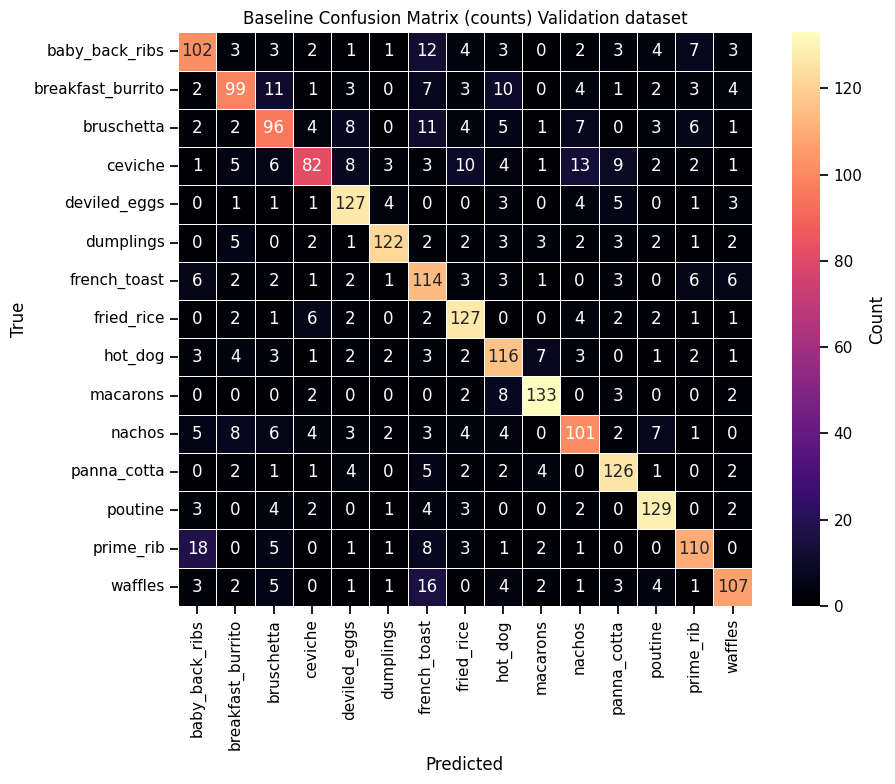

In [118]:
cm = confusion_matrix(y_true_val, y_pred_val, labels=list(range(NUM_CLASSES)))
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    cm, annot=True, fmt="d",
    cmap="magma",
    linewidths=0.5, linecolor="white",
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_names_small,
    yticklabels=class_names_small,
    ax=ax
)

ax.set_title("Baseline Confusion Matrix (counts) Validation dataset")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [42]:
pairs = []
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm[i, j] > 0:
            pairs.append((cm[i, j], i, j))

pairs.sort(reverse=True, key=lambda t: t[0])

top_k = 15
rows = []
for cnt, i, j in pairs[:top_k]:
    rows.append({
        "true_class": class_names_small[i],
        "pred_class": class_names_small[j],
        "count": int(cnt),
        "share_in_true_class_%": float(cm_norm[i, j] * 100.0),
    })
top_confusions_df = pd.DataFrame(rows)
top_confusions_df

true_class      pred_class  count  share_in_true_class_%
0           prime_rib  baby_back_ribs     21                    8.4
1             ceviche      bruschetta     20                    8.0
2             waffles    french_toast     19                    7.6
3             ceviche          nachos     18                    7.2
4   breakfast_burrito         hot_dog     17                    6.8
5           prime_rib    french_toast     17                    6.8
6      baby_back_ribs    french_toast     16                    6.4
7   breakfast_burrito    french_toast     14                    5.6
8          bruschetta    deviled_eggs     14                    5.6
9             ceviche    deviled_eggs     14                    5.6
10             nachos      bruschetta     14                    5.6
11        panna_cotta         waffles     13                    5.2
12     baby_back_ribs       prime_rib     12                    4.8
13  breakfast_burrito      bruschetta     12                    4.8
14         bruschetta          nachos     12                    4.8

In [43]:
report_df

precision    recall  f1-score      support
baby_back_ribs      0.776824  0.724000  0.749482   250.000000
breakfast_burrito   0.739130  0.680000  0.708333   250.000000
bruschetta          0.674797  0.664000  0.669355   250.000000
ceviche             0.729167  0.560000  0.633484   250.000000
deviled_eggs        0.794677  0.836000  0.814815   250.000000
dumplings           0.897638  0.912000  0.904762   250.000000
french_toast        0.666667  0.832000  0.740214   250.000000
fried_rice          0.837121  0.884000  0.859922   250.000000
hot_dog             0.766892  0.908000  0.831502   250.000000
macarons            0.948000  0.948000  0.948000   250.000000
nachos              0.707317  0.696000  0.701613   250.000000
panna_cotta         0.839506  0.816000  0.827586   250.000000
poutine             0.838057  0.828000  0.832998   250.000000
prime_rib           0.850679  0.752000  0.798301   250.000000
waffles             0.790514  0.800000  0.795229   250.000000
accuracy            0.789333  0.789333  0.789333     0.789333
macro avg           0.790466  0.789333  0.787706  3750.000000
weighted avg        0.790466  0.789333  0.787706  3750.000000

Collect confidences:   0%|          | 0/59 [00:00<?, ?it/s]

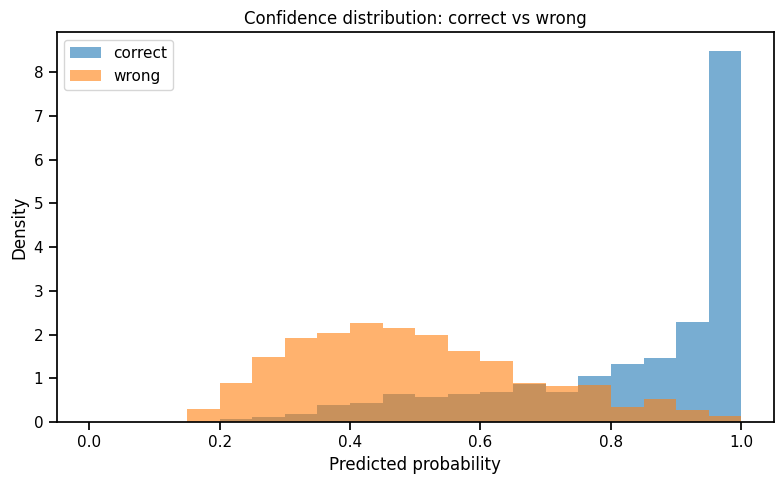

In [44]:
correct_confs, wrong_confs = [], []

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Collect confidences", leave=False):
        xb = xb.to(device); yb = yb.to(device)
        probs = torch.softmax(model(xb), dim=1)
        preds = probs.argmax(1)
        confs = probs[torch.arange(len(preds)), preds]

        correct_mask = (preds == yb)
        wrong_mask   = (preds != yb)

        correct_confs.extend(confs[correct_mask].cpu().tolist())
        wrong_confs.extend(confs[wrong_mask].cpu().tolist())

plt.figure(figsize=(8,5))
bins = np.linspace(0, 1, 21)
plt.hist(correct_confs, bins=bins, alpha=0.6, label="correct", density=True)
plt.hist(wrong_confs,   bins=bins, alpha=0.6, label="wrong",   density=True)
plt.xlabel("Predicted probability"); plt.ylabel("Density")
plt.title("Baseline [test] Confidence distribution: correct vs wrong")
plt.legend()
plt.tight_layout()
plt.show()

Collect confidences:   0%|          | 0/36 [00:00<?, ?it/s]

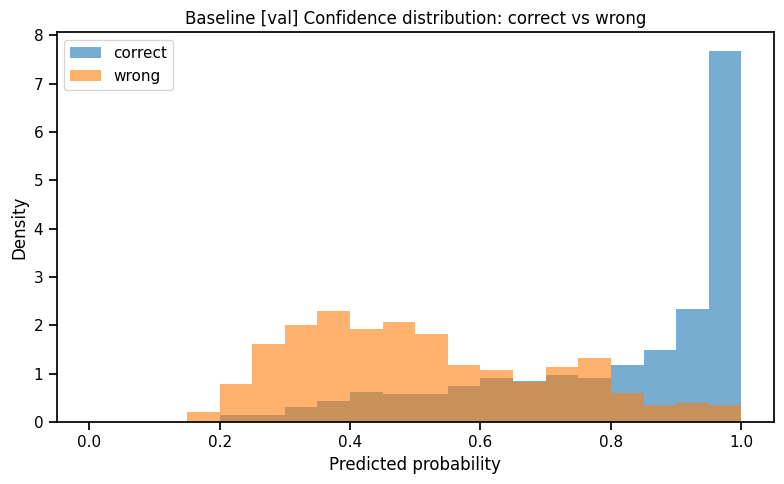

In [124]:
correct_confs, wrong_confs = [], []

with torch.no_grad():
    for xb, yb in tqdm(val_loader, desc="Collect confidences", leave=False):
        xb = xb.to(device); yb = yb.to(device)
        probs = torch.softmax(model(xb), dim=1)
        preds = probs.argmax(1)
        confs = probs[torch.arange(len(preds)), preds]

        correct_mask = (preds == yb)
        wrong_mask = (preds != yb)

        correct_confs.extend(confs[correct_mask].cpu().tolist())
        wrong_confs.extend(confs[wrong_mask].cpu().tolist())

plt.figure(figsize=(8,5))
bins = np.linspace(0, 1, 21)
plt.hist(correct_confs, bins=bins, alpha=0.6, label="correct", density=True)
plt.hist(wrong_confs,   bins=bins, alpha=0.6, label="wrong",   density=True)
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("Baseline [val] Confidence distribution: correct vs wrong")
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
def extract_state_dict(ckpt: dict):
    if "state_dict" in ckpt:
        return ckpt["state_dict"]
    if "model_state_dict" in ckpt:
        return ckpt["model_state_dict"]
    if isinstance(ckpt, dict) and any(k.endswith(".weight") or k.endswith(".bias") for k in ckpt.keys()):
        return ckpt

In [46]:
def build_baseline_model(num_classes: int):
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for p in m.parameters(): p.requires_grad = False
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(device)

In [47]:
base_ckpt_path = "best_model.pt"
base_ckpt = torch.load(base_ckpt_path, map_location=device)

model_base = build_baseline_model(NUM_CLASSES)
model_base.load_state_dict(extract_state_dict(base_ckpt), strict=True)
model_base = model_base.to(device).eval()

In [48]:
def collect_preds_probs(model, loader):
    ys, ps, pr = [], [], []  # y_true, y_pred, probs (N x C)
    model.eval()
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Collect", leave=False):
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            pr.append(probs.cpu().numpy())
            ps.append(logits.argmax(1).cpu().numpy())
            ys.append(yb.cpu().numpy())
    y = np.concatenate(ys)
    p = np.concatenate(ps)
    prob = np.concatenate(pr, axis=0)
    return y, p, prob

In [49]:
def topk_acc(prob, y_true, k):
    topk = np.argpartition(-prob, kth=k-1, axis=1)[:, :k]
    hits = np.any(topk == y_true[:,None], axis=1)
    return hits.mean()

In [50]:
y_b, p_b, prob_b = collect_preds_probs(model_base, test_loader)

Collect:   0%|          | 0/59 [00:00<?, ?it/s]

In [51]:
k = 1
top1_base = topk_acc(prob_b, y_b, k)
print(f"Top-{k} Acc | Base: {top1_base:.3f}")

Top-1 Acc | Base: 0.789


In [52]:
def expected_calibration_error(y_true, prob, n_bins=15):
    p = prob.max(axis=1)
    y_pred = prob.argmax(1)
    correct = (y_pred == y_true).astype(int)
    bins = np.linspace(0,1,n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (p >= lo) & (p < hi) if i < n_bins-1 else (p >= lo) & (p <= hi)
        if mask.sum() == 0: continue
        conf_bin = p[mask].mean()
        acc_bin  = correct[mask].mean()
        ece += (mask.mean()) * abs(acc_bin - conf_bin)
    return ece

In [84]:
f1_base = test_f1
ece_base = expected_calibration_error(y_b, prob_b)

In [54]:
metrics = []

In [55]:
metrics.append(["baseline", f1_base, top1_base, ece_base])

In [87]:
val_metrics = []

In [86]:
y_bv, p_bv, prob_bv = collect_preds_probs(model_base, val_loader)
top1_base_v = topk_acc(prob_bv, y_bv, k)

f1_base_v = val_f1

ece_base_v = expected_calibration_error(y_bv, prob_bv)

Collect:   0%|          | 0/36 [00:00<?, ?it/s]

In [88]:
val_metrics.append(["baseline", f1_base_v, top1_base_v, ece_base_v])

## Методы улучшения генерализации

Приступим к практической части задания и посмотрим на два метода улучшения генерализации модели (ее способности показывать хорошие результаты на данных, которые не были использован при обучении и подборе параметров)

В этой работе я применю и сравню Dropout (отключение случайных нейронов во время обучения) и Weight Decay (предотвращение чрезмерного увеличения параметров)

### Dropout

Dropout, или отключение случайных нейронов, задается при определении последнего (полносвязного) слоя нейронной сети. При каждой из итераций обучения отключается определенный процент нейронов

Зададим для каждого нейрона вероятность отключения 20%. Подбор был начат с 50%, постепенное понижение показало улучшение показателей, которое остановилось на вероятности, равной 20%

Dropout дает результат за счет того, что не позволяет отдельным нейронам переобучаться (это показывало бы хорошие результаты на обучающем датасете и негаивно сказывалось при использовании других данных)

In [56]:
model_do = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if USE_PRETRAINED else None)

for name, param in model_do.named_parameters():
    param.requires_grad = False

in_features = model_do.fc.in_features

model_do.fc = nn.Sequential(
    # set Dropout
    nn.Dropout(p=0.2),
    nn.Linear(in_features, NUM_CLASSES)
)

model_do = model_do.to(device)

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer_do = torch.optim.Adam(model_do.fc.parameters(), lr=1e-3)

EPOCHS = 10
history_do = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

best_val_loss = float("inf")
patience = 3
no_improve_epochs = 0
checkpoint_path = "best_model_do.pt"

for epoch in range(1, EPOCHS + 1):
    model_do.train()
    train_loss = train_acc = 0.0
    n_train = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer_do.zero_grad(set_to_none=True)
        logits = model_do(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer_do.step()

        bs = yb.size(0)
        n_train += bs
        train_loss += loss.item() * bs
        train_acc  += accuracy_from_logits(logits, yb) * bs

    train_loss /= n_train
    train_acc  /= n_train

    model_do.eval()
    val_loss = val_acc = 0.0
    n_val = 0
    for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [val]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        with torch.no_grad():
            logits = model_do(xb)
            loss = criterion(logits, yb)
        bs = yb.size(0)
        n_val += bs
        val_loss += loss.item() * bs
        val_acc  += accuracy_from_logits(logits, yb) * bs

    val_loss /= n_val
    val_acc  /= n_val

    history_do["train_loss"].append(train_loss)
    history_do["val_loss"].append(val_loss)
    history_do["train_acc"].append(train_acc)
    history_do["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} | "
          f"train_acc={train_acc*100:.1f}% val_acc={val_acc*100:.1f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save({
            "epoch": epoch,
            "model_state_dict": model_do.state_dict(),
            "optimizer_state_dict": optimizer_do.state_dict(),
            "val_loss": val_loss,
        }, checkpoint_path)
        print("new checkpoint")
    else:
        no_improve_epochs += 1
        print(f"no improvements for {no_improve_epochs} epochs in a row")

    if no_improve_epochs >= patience:
        print("early stopping")
        break

Epoch 1/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 1/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 01/10 | train_loss=1.8027 val_loss=1.2450 | train_acc=47.0% val_acc=65.2%
new checkpoint


Epoch 2/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 2/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 02/10 | train_loss=1.1640 val_loss=1.0143 | train_acc=66.6% val_acc=70.9%
new checkpoint


Epoch 3/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 3/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 03/10 | train_loss=1.0265 val_loss=0.9419 | train_acc=69.1% val_acc=71.5%
new checkpoint


Epoch 4/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 4/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 04/10 | train_loss=0.9651 val_loss=0.8993 | train_acc=70.7% val_acc=72.2%
new checkpoint


Epoch 5/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 5/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 05/10 | train_loss=0.9203 val_loss=0.8594 | train_acc=72.1% val_acc=73.1%
new checkpoint


Epoch 6/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 6/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 06/10 | train_loss=0.9018 val_loss=0.8368 | train_acc=72.1% val_acc=73.9%
new checkpoint


Epoch 7/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 7/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 07/10 | train_loss=0.8814 val_loss=0.8360 | train_acc=72.7% val_acc=73.6%
new checkpoint


Epoch 8/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 8/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 08/10 | train_loss=0.8600 val_loss=0.8177 | train_acc=73.3% val_acc=74.6%
new checkpoint


Epoch 9/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 9/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 09/10 | train_loss=0.8594 val_loss=0.8321 | train_acc=73.5% val_acc=73.6%
no improvements for 1 epochs in a row


Epoch 10/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 10/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/10 | train_loss=0.8441 val_loss=0.8133 | train_acc=73.6% val_acc=74.5%
new checkpoint


In [58]:
y_do, p_do, prob_do = collect_preds_probs(model_do, test_loader)

Collect:   0%|          | 0/59 [00:00<?, ?it/s]

In [89]:
test_acc_do, test_f1_do = evaluate(model_do, test_loader)
val_acc_do, val_f1_do = evaluate(model_do, val_loader)

In [60]:
k = 1
top1_do = topk_acc(prob_do, y_do, k)
print(f"Top-{k} Acc | Dropout: {top1_do:.3f}")

Top-1 Acc | Dropout: 0.790


In [61]:
ece_do = expected_calibration_error(y_do, prob_do)

In [62]:
metrics.append(["dropout", test_f1_do, top1_do, ece_do])

Collect confidences:   0%|          | 0/59 [00:00<?, ?it/s]

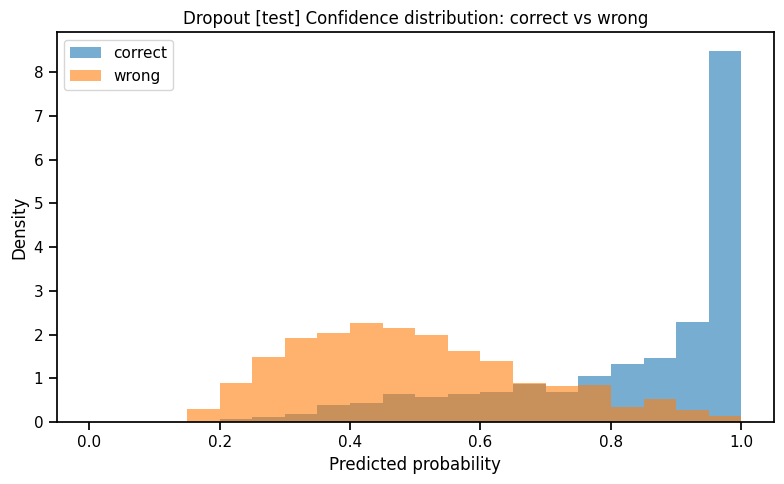

In [121]:
correct_confs_do, wrong_confs_do = [], []

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Collect confidences", leave=False):
        xb = xb.to(device)
        yb = yb.to(device)
        probs = torch.softmax(model_do(xb), dim=1)
        preds = probs.argmax(1)
        confs_do = probs[torch.arange(len(preds)), preds]

        correct_mask = (preds == yb)
        wrong_mask = (preds != yb)

        correct_confs_do.extend(confs_do[correct_mask].cpu().tolist())
        wrong_confs_do.extend(confs_do[wrong_mask].cpu().tolist())

plt.figure(figsize=(8,5))
bins = np.linspace(0, 1, 21)
plt.hist(correct_confs, bins=bins, alpha=0.6, label="correct", density=True)
plt.hist(wrong_confs,   bins=bins, alpha=0.6, label="wrong",   density=True)
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("Dropout [test] Confidence distribution: correct vs wrong")
plt.legend()
plt.tight_layout()
plt.show()

Collect confidences:   0%|          | 0/36 [00:00<?, ?it/s]

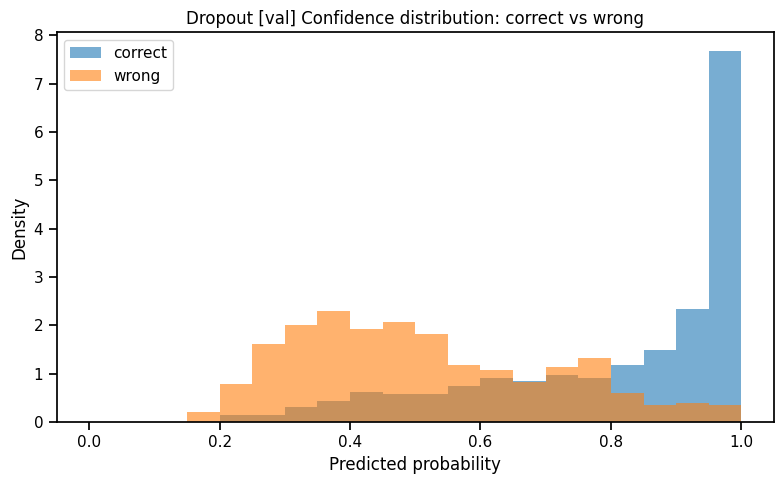

In [125]:
correct_confs_do, wrong_confs_do = [], []

with torch.no_grad():
    for xb, yb in tqdm(val_loader, desc="Collect confidences", leave=False):
        xb = xb.to(device)
        yb = yb.to(device)
        probs = torch.softmax(model_do(xb), dim=1)
        preds = probs.argmax(1)
        confs_do = probs[torch.arange(len(preds)), preds]

        correct_mask = (preds == yb)
        wrong_mask = (preds != yb)

        correct_confs_do.extend(confs_do[correct_mask].cpu().tolist())
        wrong_confs_do.extend(confs_do[wrong_mask].cpu().tolist())

plt.figure(figsize=(8,5))
bins = np.linspace(0, 1, 21)
plt.hist(correct_confs, bins=bins, alpha=0.6, label="correct", density=True)
plt.hist(wrong_confs,   bins=bins, alpha=0.6, label="wrong",   density=True)
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("Dropout [val] Confidence distribution: correct vs wrong")
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
model_do.eval()
y_true_do, y_pred_do = [], []

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Eval [test]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model_do(xb)
        preds = logits.argmax(1)
        y_true_do.extend(yb.cpu().numpy())
        y_pred_do.extend(preds.cpu().numpy())

y_true_do = np.array(y_true_do, dtype=int)
y_pred_do = np.array(y_pred_do, dtype=int)

Eval [test]:   0%|          | 0/59 [00:00<?, ?it/s]

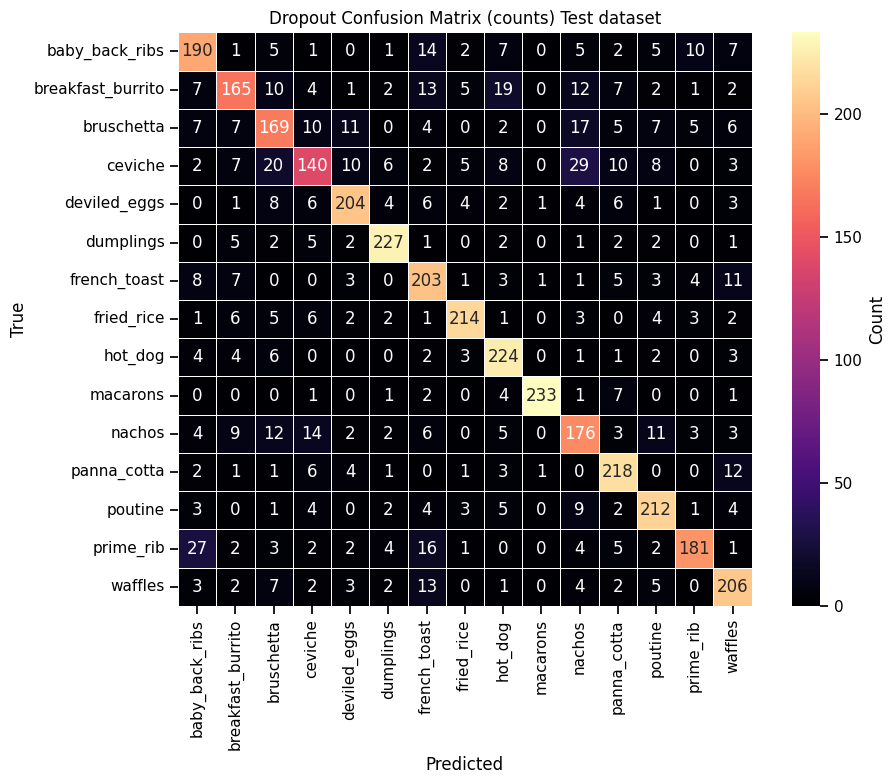

In [120]:
cm = confusion_matrix(y_true_do, y_pred_do, labels=list(range(NUM_CLASSES)))
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    cm, annot=True, fmt="d",
    cmap="magma",
    linewidths=0.5, linecolor="white",
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_names_small,
    yticklabels=class_names_small,
    ax=ax
)

ax.set_title("Dropout Confusion Matrix (counts) Test dataset")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [115]:
model_do.eval()
y_true_do_val, y_pred_do_val = [], []

with torch.no_grad():
    for xb, yb in tqdm(val_loader, desc="Eval [val]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model_do(xb)
        preds = logits.argmax(1)
        y_true_do_val.extend(yb.cpu().numpy())
        y_pred_do_val.extend(preds.cpu().numpy())

y_true_do_val = np.array(y_true_do_val, dtype=int)
y_pred_do_val = np.array(y_pred_do_val, dtype=int)

Eval [val]:   0%|          | 0/36 [00:00<?, ?it/s]

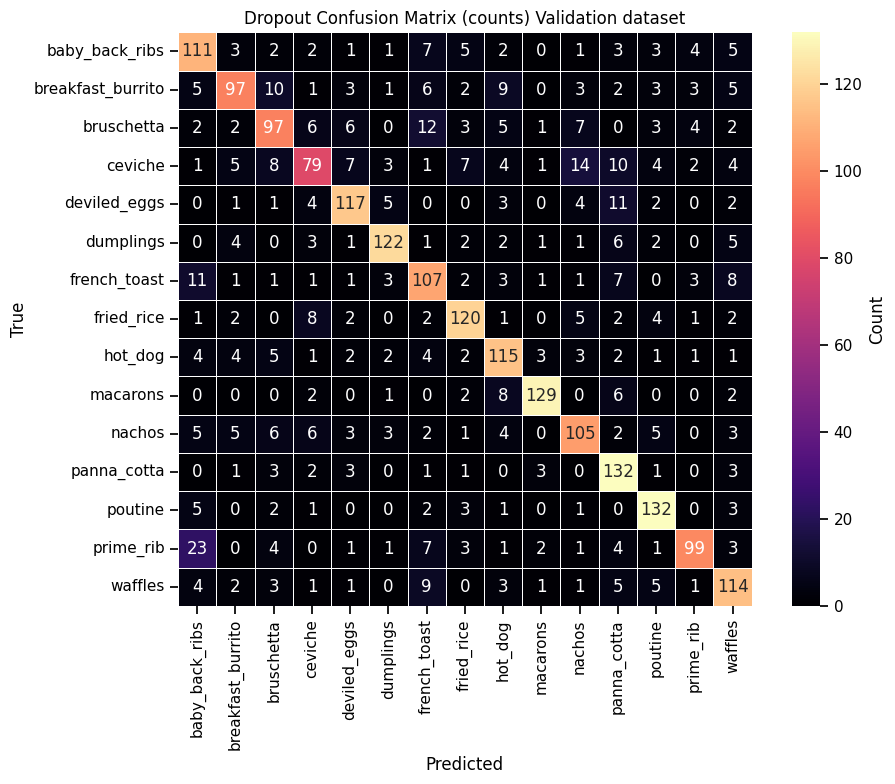

In [116]:
cm = confusion_matrix(y_true_do_val, y_pred_do_val, labels=list(range(NUM_CLASSES)))
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    cm, annot=True, fmt="d",
    cmap="magma",
    linewidths=0.5, linecolor="white",
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_names_small,
    yticklabels=class_names_small,
    ax=ax
)

ax.set_title("Dropout Confusion Matrix (counts) Validation dataset")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [90]:
y_dov, p_dov, prob_dov = collect_preds_probs(model_do, val_loader)
top1_do_v = topk_acc(prob_dov, y_dov, k)

f1_do_v = val_f1_do

ece_do_v = expected_calibration_error(y_dov, prob_dov)

Collect:   0%|          | 0/36 [00:00<?, ?it/s]

In [91]:
val_metrics.append(["dropout", f1_do_v, top1_do_v, ece_do_v])

### Weight Decay

Weight Decay позволяет оптимизировать генерализацию модели за счет добавления к функции потерь штрафа за большие значения весов

Как и в случае с Dropout, в результате применения такой стратегии мы имеем меньший риск переобучения. Здесь и выше мы говорили именно о снижении переобучения, а не о повышении генерализации, потому что переобучение — это слишком хорошо подстроенные под обучающий датасет веса, а генерализация — способность модели показывать хороший результат на данных, отличных от обучающих. То есть снижая переобучение, мы делаем нашу модель более способной к генерализации

In [66]:
model_wd = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if USE_PRETRAINED else None)

for name, param in model_wd.named_parameters():
    param.requires_grad = False

in_features = model_wd.fc.in_features

model_wd.fc = nn.Sequential(
    nn.Linear(in_features, NUM_CLASSES)
)

model_wd = model_wd.to(device)

Weight Decay задается в оптимизаторе, поскольку именно этот компонент отвечает за обновление весов (Weight Decay модифицирует этот шаг) при обучении. Зададим размер шага 1e-3 и силу L2-регуляризации 0.0001

In [96]:
criterion = nn.CrossEntropyLoss()
optimizer_wd = torch.optim.AdamW(
    # set Weight Decay
    model_wd.fc.parameters(),
    lr=1e-3,
    weight_decay=0.0001,
)

EPOCHS = 10
history_wd = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

best_val_loss = float("inf")
patience = 3
no_improve_epochs = 0
checkpoint_path = "best_model_wd.pt"

for epoch in range(1, EPOCHS + 1):
    model_wd.train()
    train_loss = train_acc = 0.0
    n_train = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer_wd.zero_grad(set_to_none=True)
        logits = model_wd(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer_wd.step()

        bs = yb.size(0)
        n_train += bs
        train_loss += loss.item() * bs
        train_acc  += accuracy_from_logits(logits, yb) * bs

    train_loss /= n_train
    train_acc  /= n_train

    model_wd.eval()
    val_loss = val_acc = 0.0
    n_val = 0
    for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [val]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        with torch.no_grad():
            logits = model_wd(xb)
            loss = criterion(logits, yb)
        bs = yb.size(0)
        n_val += bs
        val_loss += loss.item() * bs
        val_acc  += accuracy_from_logits(logits, yb) * bs

    val_loss /= n_val
    val_acc  /= n_val

    history_wd["train_loss"].append(train_loss)
    history_wd["val_loss"].append(val_loss)
    history_wd["train_acc"].append(train_acc)
    history_wd["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} | "
          f"train_acc={train_acc*100:.1f}% val_acc={val_acc*100:.1f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save({
            "epoch": epoch,
            "model_state_dict": model_wd.state_dict(),
            "optimizer_state_dict": optimizer_wd.state_dict(),
            "val_loss": val_loss,
        }, checkpoint_path)
        print("new checkpoint")
    else:
        no_improve_epochs += 1
        print(f"no improvements for {no_improve_epochs} epochs in a row")

    if no_improve_epochs >= patience:
        print("early stopping")
        break

Epoch 1/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 1/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 01/10 | train_loss=0.6834 val_loss=0.7877 | train_acc=79.0% val_acc=75.0%
new checkpoint


Epoch 2/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 2/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 02/10 | train_loss=0.6595 val_loss=0.8003 | train_acc=79.4% val_acc=75.1%
no improvements for 1 epochs in a row


Epoch 3/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 3/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 03/10 | train_loss=0.6455 val_loss=0.7879 | train_acc=80.0% val_acc=75.5%
no improvements for 2 epochs in a row


Epoch 4/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 4/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 04/10 | train_loss=0.6312 val_loss=0.8020 | train_acc=80.3% val_acc=75.3%
no improvements for 3 epochs in a row
early stopping


In [97]:
y_wd, p_wd, prob_wd = collect_preds_probs(model_wd, test_loader)

Collect:   0%|          | 0/59 [00:00<?, ?it/s]

In [98]:
test_acc_wd, test_f1_wd = evaluate(model_wd, test_loader)
val_acc_wd, val_f1_wd = evaluate(model_wd, val_loader)

In [99]:
k = 1
top1_wd = topk_acc(prob_wd, y_wd, k)
print(f"Top-{k} Acc | Dropout: {top1_wd:.3f}")

Top-1 Acc | Dropout: 0.790


In [100]:
ece_wd = expected_calibration_error(y_wd, prob_wd)

In [101]:
metrics.append(["weight decay", test_f1_wd, top1_wd, ece_wd])

Collect confidences:   0%|          | 0/59 [00:00<?, ?it/s]

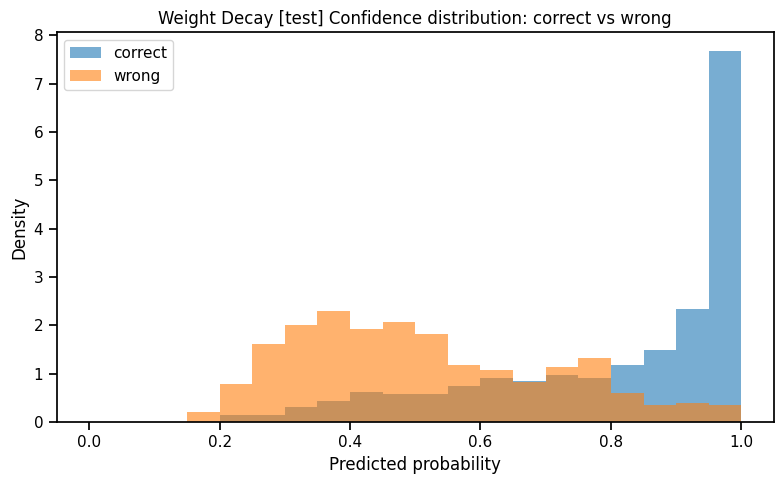

In [126]:
correct_confs_wd, wrong_confs_wd = [], []

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Collect confidences", leave=False):
        xb = xb.to(device)
        yb = yb.to(device)
        probs = torch.softmax(model_wd(xb), dim=1)
        preds = probs.argmax(1)
        confs_wd = probs[torch.arange(len(preds)), preds]

        correct_mask = (preds == yb)
        wrong_mask = (preds != yb)

        correct_confs_wd.extend(confs_wd[correct_mask].cpu().tolist())
        wrong_confs_wd.extend(confs_wd[wrong_mask].cpu().tolist())

plt.figure(figsize=(8,5))
bins = np.linspace(0, 1, 21)
plt.hist(correct_confs, bins=bins, alpha=0.6, label="correct", density=True)
plt.hist(wrong_confs,   bins=bins, alpha=0.6, label="wrong",   density=True)
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("Weight Decay [test] Confidence distribution: correct vs wrong")
plt.legend()
plt.tight_layout()
plt.show()

Collect confidences:   0%|          | 0/36 [00:00<?, ?it/s]

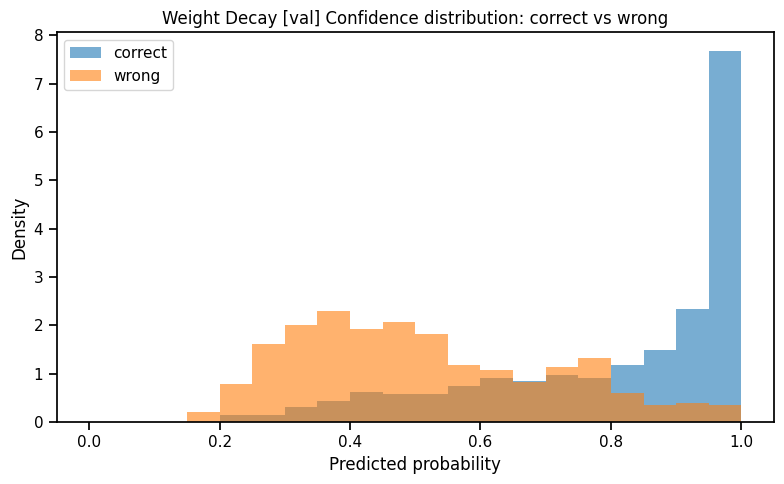

In [127]:
correct_confs_wd, wrong_confs_wd = [], []

with torch.no_grad():
    for xb, yb in tqdm(val_loader, desc="Collect confidences", leave=False):
        xb = xb.to(device)
        yb = yb.to(device)
        probs = torch.softmax(model_wd(xb), dim=1)
        preds = probs.argmax(1)
        confs_wd = probs[torch.arange(len(preds)), preds]

        correct_mask = (preds == yb)
        wrong_mask = (preds != yb)

        correct_confs_wd.extend(confs_wd[correct_mask].cpu().tolist())
        wrong_confs_wd.extend(confs_wd[wrong_mask].cpu().tolist())

plt.figure(figsize=(8,5))
bins = np.linspace(0, 1, 21)
plt.hist(correct_confs, bins=bins, alpha=0.6, label="correct", density=True)
plt.hist(wrong_confs,   bins=bins, alpha=0.6, label="wrong",   density=True)
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("Weight Decay [val] Confidence distribution: correct vs wrong")
plt.legend()
plt.tight_layout()
plt.show()

In [102]:
model_wd.eval()
y_true_wd, y_pred_wd = [], []

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Eval [test]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model_wd(xb)
        preds = logits.argmax(1)
        y_true_wd.extend(yb.cpu().numpy())
        y_pred_wd.extend(preds.cpu().numpy())

y_true_wd = np.array(y_true_wd, dtype=int)
y_pred_wd = np.array(y_pred_wd, dtype=int)

Eval [test]:   0%|          | 0/59 [00:00<?, ?it/s]

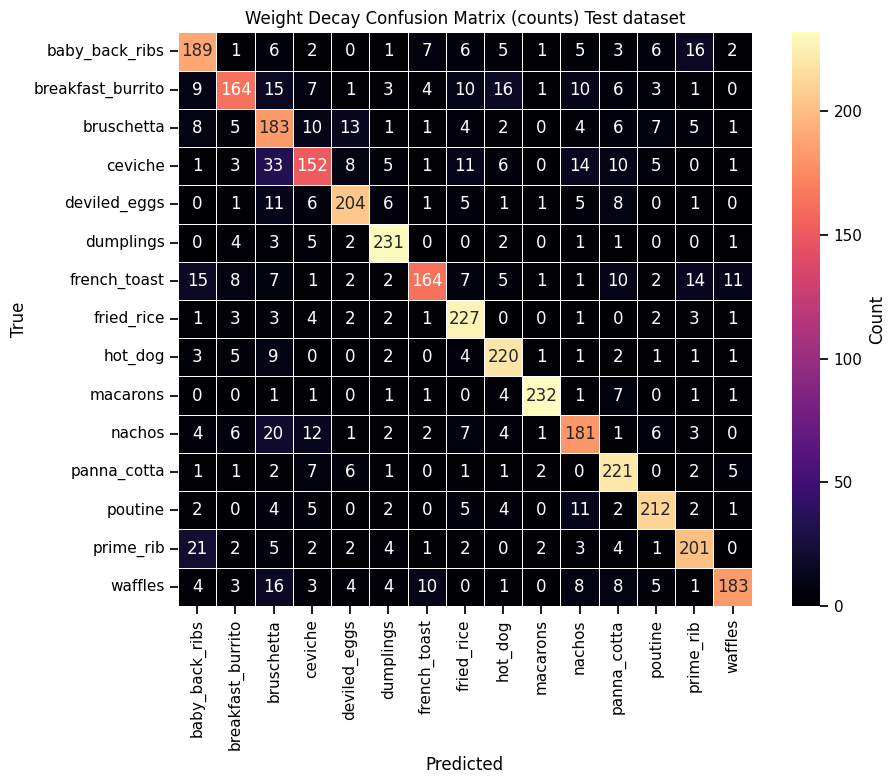

In [114]:
cm = confusion_matrix(y_true_wd, y_pred_wd, labels=list(range(NUM_CLASSES)))
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    cm, annot=True, fmt="d",
    cmap="magma",
    linewidths=0.5, linecolor="white",
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_names_small,
    yticklabels=class_names_small,
    ax=ax
)

ax.set_title("Weight Decay Confusion Matrix (counts) Test dataset")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [112]:
model_wd.eval()
y_true_wd_val, y_pred_wd_val = [], []

with torch.no_grad():
    for xb, yb in tqdm(val_loader, desc="Eval [val]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model_wd(xb)
        preds = logits.argmax(1)
        y_true_wd_val.extend(yb.cpu().numpy())
        y_pred_wd_val.extend(preds.cpu().numpy())

y_true_wd_val = np.array(y_true_wd_val, dtype=int)
y_pred_wd_val = np.array(y_pred_wd_val, dtype=int)

Eval [val]:   0%|          | 0/36 [00:00<?, ?it/s]

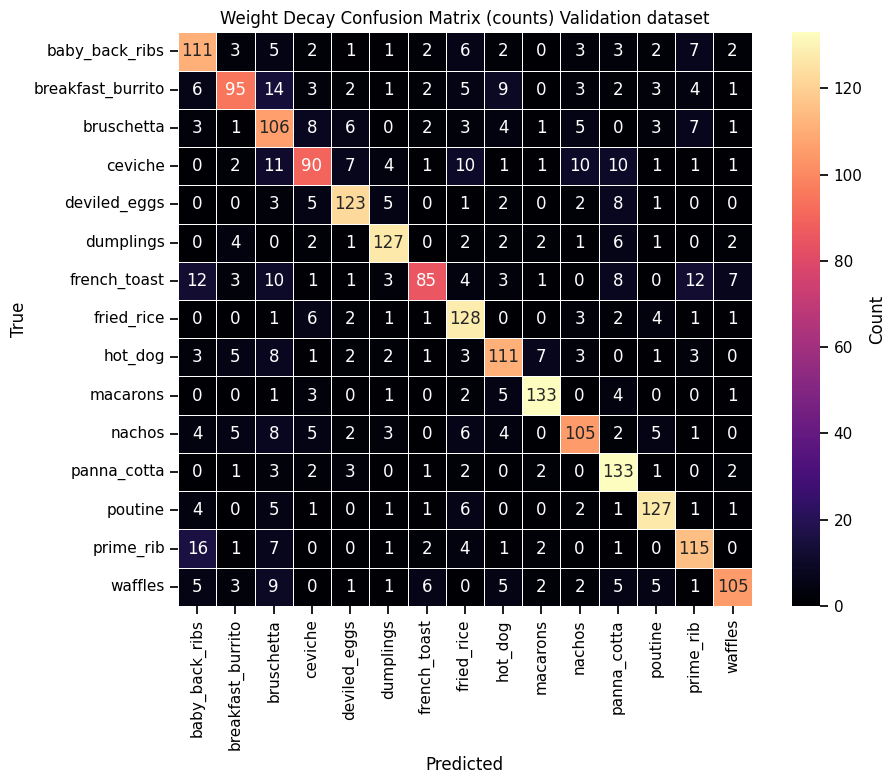

In [113]:
cm = confusion_matrix(y_true_wd_val, y_pred_wd_val, labels=list(range(NUM_CLASSES)))
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    cm, annot=True, fmt="d",
    cmap="magma",
    linewidths=0.5, linecolor="white",
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_names_small,
    yticklabels=class_names_small,
    ax=ax
)

ax.set_title("Weight Decay Confusion Matrix (counts) Validation dataset")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [104]:
y_wdv, p_wdv, prob_wdv = collect_preds_probs(model_wd, val_loader)
top1_wd_v = topk_acc(prob_wdv, y_wdv, k)

f1_wd_v = val_f1_wd

ece_wd_v = expected_calibration_error(y_wdv, prob_wdv)

Collect:   0%|          | 0/36 [00:00<?, ?it/s]

In [105]:
val_metrics.append(["weight decay", f1_wd_v, top1_wd_v, ece_wd_v])

## Анализ и подведение итогов

Ниже представлены таблицы с метриками трех реализаций модели (baseline, dropout, weight decay) для тестовой и валидационной выборок соответственно. Далее разберем метрики для модели с применением Dropout и Weight Decay в сравнении с Baseline

#### Метрики моделей на тестовом датасете

In [110]:
pd.DataFrame(metrics, columns=["model_name", "f1_macro", "top_1", "ece"])

model_name  f1_macro     top_1       ece
0      baseline  0.787706  0.789333  0.032803
1       dropout  0.788811  0.789867  0.052539
2  weight decay  0.789754  0.790400  0.024052

#### Метрики моделей на валидационном датасете

In [111]:
pd.DataFrame(val_metrics, columns=["model_name", "f1_macro", "top_1", "ece"])

model_name  f1_macro     top_1       ece
0      baseline  0.750301  0.751556  0.027456
1       dropout  0.743607  0.744889  0.033451
2  weight decay  0.751949  0.752889  0.015278

### Анализ метрик модели с применением Dropout

#### F1-macro
Слегка выросла на тестовом датасете (0.787706 и 0.788811) и при этом заметно снизилась на валидационном (0.750301 и 0.743607). Добавление Dropout ухудшило precision и recall между классами

#### Top-1
Видим, что Top-1 для модели с Dropout крайне незначительно выросла на тестовых данных (0.789333 и 0.789867) и при этом более ощутимо снизилась на валидационных (с 0.751556 для Baseline до 0.744889 для Dropout)

#### ECE
В отличии от предыдущих двух, для этой метрики можем наблюдать рост как на тестовых, так и на валидационных данных. Для нас целью является наоборот снижение ECE, так как эта метрика показывает, насколько предсказания модели далеки о реальных значений


#### Вывод по модели с применением Dropout
В целом для модели с применением Dropout с rate = 0.2 (лучший из вариантов) мы получили ухудшение метрик модели: снизилось среднее качество предсказаний по всем классам, стала меньше доля корректных предсказаний и ухудшилась калибровка

Следовательно, способность модели к генерализации не повысилась, а даже снизилась по сравнению с Baseline. Разрыв между точностью для тестовых и валидационных данных увеличился по сравнению с Baseline. Причиной этому может быть то, что регуляризация не уменьшила переобучение, а усилила недообучение, особенно с учётом того, что мы переобучали только финальный слой

### Анализ метрик модели с применением Weight Decay

#### F1-macro
Метрика F1-macro показывает улучшение общей способности к предсказаниям модели с применением Weight Decay по сравнению с Baseline. На тестовых данных: 0.787706 и 0.789754б на валидационных: 0.750301 и 0.751949

#### Top-1
Метрика Top-1 дала небольшой прирост как на тестовых, так и на валидационных данных, что говорит об устойчивом (пусть и не очень большом) улучшении доли корректных предсказаний

#### ECE
Expected calibration error показывает достаточно существенное снижение: 0.032803 и 0.024052 для тестовых данных, 0.027456 и 0.015278 для валидационных, что говорит о том, что веса модели стали лучше отражать реальную точность

#### Вывод по модели с применением Weight Decay

Модель с применением Weight Decay показала улучшение метрик по сравнению с Baseline и при этом не создала разрыв между метриками для тестовых и валидационных данных.

Применение Weight Decay помогло снизить избыточную уверенность модели и улучшило ее способность к генерализации

## Вывод

Лучше всего в этой работе себя показала модель с применением Weight Decay, которая показала улучшение метрик по сравнению с Baseline и не повысила признаки переобученнности, при этом улучшив генерализацию

Применение Dropout наоборот не принесло пользы, возможно, из-за того, что обучаемым был оставлен только один слой модели

В дальнейшем было бы интересно увеличить обучаемую часть модели и сравнить методы повышения генерализации на модели с бо́льшим количеством обучаемых слоев